In [ ]:
########SCRIPT TO EXTRACT DATAS################
import pandas as pd
import numpy as np
import glob


# Lecture des fichiers
file_list = sorted(glob.glob(f"thickness.dat")) 
print(file_list)
# Construire la grille x positive commune
all_x_values = set()
for filename in file_list:
    if 'chains' in filename:
        df = pd.read_csv(filename, delim_whitespace=True, header=None, usecols=[0, 3], names=["x", "y"])
    else:
        df = pd.read_csv(filename, delim_whitespace=True, header=None, names=["x", "y"])
    all_x_values.update(x for x in df["x"])

x_full = sorted(all_x_values)
x_df_template = pd.DataFrame({"x": x_full})

# Liste des résultats à fusionner
all_results = [x_df_template.copy()]
curve_index = 1  # Compteur pour y1, y2, ..., y6

for filename in file_list:
    if 'chains' in filename:
        df = pd.read_csv(filename, delim_whitespace=True, header=None, usecols=[0, 3], names=["x", "y"])
    else:
        df = pd.read_csv(filename, delim_whitespace=True, header=None, names=["x", "y"])
    subset = df
    #display(subset)
    label = f"y{curve_index}"
    raw_col = f"{label}_raw"

    grouped = subset.groupby("x")["y"].mean().reset_index().rename(columns={"y": raw_col})
    grouped = pd.merge(x_df_template, grouped, on="x", how="left").fillna(0)

    final_df = grouped[["x", raw_col]]
    all_results.append(final_df.drop(columns="x"))

"""
    for sign, subset in [("neg", df[df["x"] < 0]), ("pos", df[df["x"] > 0])]:
        subset = subset.copy()
        subset["x"] = subset["x"].abs()

        label = f"y{curve_index}"
        raw_col = f"{label}_raw"
        norm_col = f"{label}_norm"

        # Grouper par x (si doublons), moyenne
        grouped = subset.groupby("x")["y"].mean().reset_index().rename(columns={"y": raw_col})
        grouped = pd.merge(x_df_template, grouped, on="x", how="left").fillna(0)

        # Normalisation
        total = grouped[raw_col].sum()
        grouped[norm_col] = grouped[raw_col] / total if total != 0 else grouped[raw_col]

        # Conserver les colonnes
        final_df = grouped[["x", raw_col, norm_col]]
        all_results.append(final_df.drop(columns="x"))

        curve_index += 1
"""
# Fusion finale
result = pd.concat(all_results, axis=1)

# Sauvegarde
result.to_csv(input_dir+f"dens-{prof}.dat", sep="\t", index=False, float_format="%.6f")

# Moyennes et erreurs sur PMF
dens_cols = [col for col in result.columns if col.endswith("raw")]
dens_array = result[dens_cols].values

dens_stats = result[["x"]].copy()
dens_stats["dens_mean"] = np.mean(dens_array, axis=1)
dens_stats["std_dev"] = np.std(dens_array, axis=1, ddof=1)
dens_stats["std_error"] = dens_stats["std_dev"] / np.sqrt(len(dens_cols))

dens_stats.to_csv(input_dir+f"dens_{prof}_moyen.dat", sep="\t", index=False, float_format="%.6f")

print("\nDensité moyenne et erreurs :")
print(dens_stats)

In [ ]:
import gzip
import glob
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import similaritymeasures as sm

aa=['GLYD', 'SCP', 'SCA', 'SCV', 'SCL', 'SCI', 'SCF', 'SCY', 'SCW', 'SCM','SCS', 'SCT','SCN', 'SCQ',
    'SCHE', 'SCHD', 'SCHP-N', 'SCK-N', 'SCKN', 'SCR-N', 'SCRN', 'SCCM-N', 'SCC', 'SCD-N',
    'SCDN', 'SCE-N', 'SCEN']
ll=['GLYD', 'P', 'A', 'V', 'L', 'I', 'F', 'Y$^{0}$', 'W', 'M', 'S', 'T','N', 'Q', 
    'HSE$^{0}$', 'HSD$^{0}$', 'HSP$^{+}$', 'K$^{+}$', 'K$^{0}$', 'R$^{+}$', 'R$^{0}$', 'C$^{-}$', 'C$^{0}$', 'D$^{-}$',
    'D$^{0}$', 'E$^{-}$', 'E$^{0}$']

traj=[1,2,3]
ext='5res'
#Définition des chemins
homoPOPC='/media/bories/Backup/bories/Documents/Travail/results/homoPOPC-aa/homoPOPC{}/analyses/traj{}/'

#Système étudié :
ApL=homoPOPC+'data/ApL-POPC.dat'
dens=homoPOPC+'data/densityProfiles/density-{}.dat'
thickness=homoPOPC+'data/thickness.dat'
density_profile=homoPOPC+'data/densityProfiles/profile-{}{}.dat'
order_parameter=homoPOPC+'data/orderParameters/orderparameters-{}{}.dat'
com=homoPOPC+'data/solutes/{}-com{}.dat'
data=homoPOPC+'data/energy.dat'
dop=homoPOPC+'data/orderParameters/orderparameters-{}{}.dat'

skip=400


In [32]:
#Fonctions


def plot_all(if_acid, data_input_file, fin_eq, col_name, y_axis_name):
    def load_traj_data(acid_suffix, traj_indices):
        data = []
        for idx in traj_indices:
            file_path = data_input_file.format(acid_suffix, idx)
            temp = pd.read_table(file_path, sep="\s+", skiprows=range(1, fin_eq))
            data.extend(temp[col_name].values)
        return data

    k_vals = []
    e_vals = []

    if if_acid:
        for acid in aa:
            traj_indices = [4, 2, 3] if acid in ['GLYD', 'SCA', 'SCP', 'SCV', 'SCW'] else [1, 2, 3]
            data = load_traj_data(f'-{acid}', traj_indices)
            k_vals.append(np.mean(data))
            e_vals.append(np.std(data) / np.sqrt(len(data)))

        df = pd.DataFrame({'aa': aa, 'k': k_vals, 'e': e_vals})

        plt.figure(figsize=(10, 2))
        plt.errorbar(df['aa'], df['k'], df['e'], color='k', fmt='.', linewidth=1, label='0.20M')
        plt.xlabel("side chain analog", fontsize=12)
        plt.ylabel(y_axis_name, fontsize=12)
        plt.xticks([])  # Empty tick labels for aesthetics
        # plt.legend(loc='best', prop={'size': 7})  # Uncomment if needed
    else:
        data = load_traj_data('-NONE', traj)
        k_vals.append(np.mean(data))
        e_vals.append(np.std(data) / np.sqrt(len(data)))
        df = pd.DataFrame({'aa': ['popc'], 'k': k_vals, 'e': e_vals})

    return df


def acm(x, y, z):
    """
    Calculates the area compressibility modulus K_A using the formula:
    K_A = k_B * T * (<A> / <(ΔA)^2>)
    
    Parameters:
        x, y, z : arrays of box dimensions over time (same length)
    
    Returns:
        K_A : area compressibility modulus (in g·s⁻², equivalent to dyn/cm)
    """
    k_B = 1.380649  # Boltzmann constant in A²·g·s⁻²·K⁻¹
    T = 303.15      # Temperature in Kelvin

    # Compute surface area A over time (in Å²)
    A = 2 * (x * y + x * z + y * z)

    # Mean surface area
    Aa = np.mean(A)

    # Mean square fluctuation of A (i.e., variance)
    dAa = np.var(A, ddof=0)

    # Area compressibility modulus
    K_a = k_B * T * (Aa / dAa) if dAa != 0 else np.nan  # Avoid division by zero

    return K_a


    
cell_launch=0

def area_compressibility_modulus(aa, if_acid, fin_eq):
    """
    Computes the area compressibility modulus (K_A) for each amino acid (or POPC if not acid).
    
    Parameters:
        aa       : list of amino acids
        if_acid  : boolean flag indicating whether to compute for acids or for POPC
        fin_eq   : number of initial rows to skip (equilibration period)
    
    Returns:
        DataFrame with columns: 'aa' (amino acid or 'popc'), 'k' (mean K_A), 'e' (standard error)
    """
    def read_and_compute(traj_ids, acid_suffix=''):
        """Reads trajectory data and computes K_A values for each segment."""
        values = []
        for traj_id in traj_ids:
            file_path = ApL.format(acid_suffix, traj_id)
            df = pd.read_table(file_path, sep=r"\s+", skiprows=range(1, fin_eq))
            
            segment_len = len(df) // 4  # Divide trajectory into 4 equal parts
            for j in range(4):
                start, end = j * segment_len, (j + 1) * segment_len
                x, y, z = df['X'].iloc[start:end], df['Y'].iloc[start:end], df['Z'].iloc[start:end]
                values.append(acm(x, y, z))
        return values

    results = []

    if if_acid:
        for acid in aa:
            traj_ids = [4, 2, 3] if acid in ['GLYD', 'SCA', 'SCP', 'SCV', 'SCW'] else [1, 2, 3]
            ka_values = read_and_compute(traj_ids, f'-{acid}')
            results.append({
                'aa': acid,
                'k': np.mean(ka_values),
                'e': np.std(ka_values, ddof=1) / np.sqrt(len(ka_values))  # standard error
            })
    else:
        traj_ids = [1, 2, 3]
        ka_values = read_and_compute(traj_ids)
        results.append({
            'aa': 'popc',
            'k': np.mean(ka_values),
            'e': np.std(ka_values, ddof=1) / np.sqrt(len(ka_values))
        })
    return pd.DataFrame(results)

def generate_profile(acid, element, popc):
    """
    Generates a density profile across the membrane for a given element.
    
    Parameters:
        acid    : name of the amino acid analog (or None for POPC)
        element : density component to read (e.g. 'total', 'water', etc.)
        popc    : boolean indicating whether it's a POPC-only simulation
    
    Returns:
        DataFrame with columns: '#z', density columns for each traj and mirror, mean, standard error
    """
    # Initialize z values (in nm instead of Å)
    z_values = [i / 10 for i in range(5, 555, 10)]
    profile_df = pd.DataFrame(z_values, columns=['#z'])

    # Select trajectory numbers depending on acid
    traj_numbers = [4, 2, 3] if acid in ['GLYD', 'SCA', 'SCP', 'SCV', 'SCW'] else [1, 2, 3]

    for i, traj_id in enumerate(traj_numbers):
        # Construct file path and load data
        suffix = f'-{acid}' if not popc else ''
        df = pd.read_table(dens.format(suffix, traj_id, element), sep=r"\s+")

        # Drop unneeded columns
        df.drop(columns=['density1', 'density_moy'], inplace=True, errors='ignore')

        # Separate positive and negative z values
        df_pos = df[df['#z'] > 0].copy()
        df_neg = df[df['#z'] < 0].copy()
        df_neg.loc[:, '#z'] = -df_neg['#z']  # Mirror z-axis to positive

        # Merge both mirrored profiles into the main dataframe
        profile_df = profile_df.merge(df_pos, on='#z', how='left', suffixes=('', f'_+{i+1}'))
        profile_df = profile_df.merge(df_neg, on='#z', how='left', suffixes=('', f'_-{i+1}'))

    # Replace missing values with 0
    profile_df.fillna(0, inplace=True)

    # Calculate mean and standard error from all mirrored profiles
    density_columns = [col for col in profile_df.columns if col != '#z']
    profile_df['mean'] = profile_df[density_columns].mean(axis=1)
    profile_df['se'] = profile_df[density_columns].std(axis=1, ddof=1) / np.sqrt(len(density_columns))

    return profile_df

def make_ab2c_dens(aa):
    """
    Computes the area between density profiles of POPC alone and POPC with each amino acid analog,
    for a set of profile components.

    Parameters:
        aa : list of amino acid analog names

    Returns:
        areas_p : list of lists, each containing area differences for each element per amino acid
    """
    profiles = ["total", "water", "popc", "choline", "phosphate", "carbonyl", "chains"]
    areas_p = []

    for element in profiles:
        element_areas = []

        # Generate POPC-only profile
        df_popc = generate_profile('', element, popc=True)
        x = df_popc['#z'].values
        y = df_popc['mean'].values
        popc_alone = np.column_stack((x, y))

        # Generate profile with each amino acid and compute area difference
        for acid in aa:
            df_acid = generate_profile(acid, element, popc=False)
            x = df_acid['#z'].values
            y = df_acid['mean'].values
            popc_aa = np.column_stack((x, y))

            area = sm.area_between_two_curves(popc_alone, popc_aa)
            element_areas.append(area)

        areas_p.append(element_areas)

    return areas_p


def water_depth(aa, popc):
    """
    Computes the average depth at which water density drops below 0.01 (Å⁻³) for each system.
    
    Parameters:
        aa   : list of amino acid analogs (ignored if popc=True)
        popc : boolean flag indicating POPC-only system

    Returns:
        DataFrame with columns: 'mean' and 'se' for each system
    """
    water_depths = []

    # Define density column suffixes to check
    suffixes = ['', '_-1', '_+2', '_-2', '_+3', '_-3']
    density_indices = ['3', '4', '5']

    # Choose systems to analyze
    systems = ['popc'] if popc else aa

    for system in systems:
        df = generate_profile('' if popc else system, 'water', popc)
        
        # Focus on the central region of the membrane
        df_filtered = df[(df['#z'] > -40) & (df['#z'] < 40)]

        z_cutoffs = []

        for suffix in suffixes:
            for idx in density_indices:
                col_name = f'density{idx}{suffix}'
                if col_name in df_filtered.columns:
                    below_threshold = df_filtered[df_filtered[col_name] < 0.01]
                    if not below_threshold.empty:
                        z_cutoffs.append(below_threshold['#z'].max())

        # Compute mean and standard error
        if z_cutoffs:
            mean_depth = np.mean(z_cutoffs)
            std_error = np.std(z_cutoffs, ddof=1) / np.sqrt(len(z_cutoffs))
        else:
            mean_depth = np.nan
            std_error = np.nan

        water_depths.append({'mean': mean_depth, 'se': std_error})

    return pd.DataFrame(water_depths)


def df_scd(t, acid):
    """
    Computes the averaged SCD (Segmental Order Parameter) per carbon for each lipid chain.

    Parameters:
        t     : trajectory number
        acid  : amino acid analog name (or empty string for POPC)

    Returns:
        df_chain2, df_chain3 : DataFrames with columns ['Carbon', '-SCD', 'STD_Error']
    """
    chains = ["chain2", "chain3"]
    blocks = ['3', '4', '5']
    result = {}

    for chain in chains:
        # Load all 3 blocks for the current chain
        dfs = [pd.read_table(dop.format(acid, t, chain, blk), sep=r"\s+") for blk in blocks]

        # Define carbon number range
        carbon_range = range(2, 19) if chain == "chain2" else range(2, 17)
        df = pd.DataFrame({'Carbon': carbon_range})

        # Merge each block into the dataframe
        for i, df_blk in enumerate(dfs, start=2):  # Start from 2 to label SCD2, SCD3, SCD4
            df = df.merge(df_blk, on='Carbon', how='left')
            df.rename(columns={
                '-SCD': f'-SCD{i}',
                'STD_Error': f'STD_Error{i}'
            }, inplace=True)

        # Compute average SCD and standard error across the 3 blocks
        df['-SCD'] = df[[f'-SCD{i}' for i in range(2, 5)]].mean(axis=1)
        df['STD_Error'] = df[[f'STD_Error{i}' for i in range(2, 5)]].mean(axis=1)

        # Drop intermediate columns
        df.drop(columns=[f'-SCD{i}' for i in range(2, 5)] +
                       [f'STD_Error{i}' for i in range(2, 5)], inplace=True)

        result[chain] = df

    return result['chain2'], result['chain3']


def merge_carbon(df1, df2, df3, carbon):
    """
    Merges SCD data from three replicates (df1, df2, df3) and computes the average
    SCD and standard error per carbon.

    Parameters:
        df1, df2, df3 : DataFrames with columns ['Carbon', '-SCD', 'STD_Error']
        carbon        : iterable of carbon indices to keep

    Returns:
        DataFrame with columns: ['Carbon', '-SCD', 'STD_Error']
    """
    # Initialize base DataFrame with Carbon column
    df = pd.DataFrame({'Carbon': carbon})

    # Merge the three dataframes
    for i, sub_df in enumerate([df1, df2, df3], start=1):
        df = df.merge(sub_df, on='Carbon', how='left', suffixes=('', f'_{i}'))
        df.rename(columns={
            '-SCD': f'-SCD{i}',
            'STD_Error': f'STD_Error{i}'
        }, inplace=True)

    # Compute average SCD and standard error
    df['-SCD'] = df[[f'-SCD{i}' for i in range(1, 4)]].mean(axis=1)
    df['STD_Error'] = df[[f'STD_Error{i}' for i in range(1, 4)]].mean(axis=1)

    # Drop intermediate replicate columns
    df.drop(columns=[f'-SCD{i}' for i in range(1, 4)] +
                   [f'STD_Error{i}' for i in range(1, 4)], inplace=True)

    return df

    
def make_ab2c_dop(dfpopc, dfaa):
    """
    Computes the area between the SCD curves of POPC alone and POPC with an amino acid.

    Parameters:
        dfpopc : DataFrame with columns ['Carbon', '-SCD'] for POPC
        dfaa   : DataFrame with columns ['Carbon', '-SCD'] for POPC + amino acid

    Returns:
        area : numeric value of the area between the two SCD curves
    """
    # Convert POPC data to 2D array [Carbon, -SCD]
    popc_alone = np.column_stack((dfpopc['Carbon'].values, dfpopc['-SCD'].values))

    # Convert AA system data to 2D array [Carbon, -SCD]
    popc_aa = np.column_stack((dfaa['Carbon'].values, dfaa['-SCD'].values))

    # Compute area between the two curves
    area = sm.area_between_two_curves(popc_alone, popc_aa)

    return area

        

In [33]:
#Membrane originelle
traj=[1,2,3]
thk_POPC=plot_all(False, thickness, skip, 'thickness', 'Thickness ($\AA$)')
print('\n DP-P : ', thk_POPC)

apl_POPC=plot_all(False, ApL, skip, 'A_L', 'ApL ($\AA$$^{2}$)')
print('\n ApL : ', apl_POPC)

wdp_POPC=water_depth(aa, True)
#water_depth(aa, True)
print('\n DH2O : ', wdp_POPC)

acm_POPC=area_compressibility_modulus(aa, False, skip)
print('\n K_A : ', acm_POPC)




 DP-P :       aa          k         e
0  popc  39.132514  0.005814

 ApL :       aa          k         e
0  popc  64.610214  0.041443

 DH2O :          mean        se
0  10.388889  0.076222

 K_A :       aa           k          e
0  popc  224.326905  10.555448


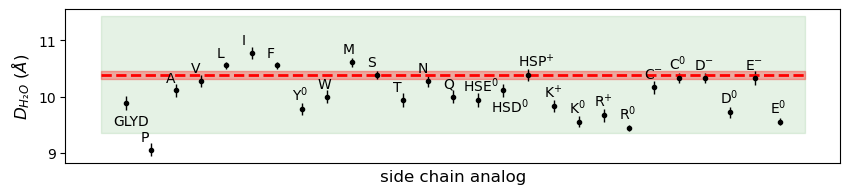

In [34]:
#water depth penetration
traj=[1, 2, 3]
d=water_depth(aa, False)
#display(d)
plt.figure(figsize=(10,2))
#plt.scatter(aa, df['{}_moy'.format('water')], marker='.', color='k', linewidth=3, label='water')
plt.errorbar(ll, d['mean'], d['se'], color='k', linewidth=1, fmt='.')
for l in range(len(ll)):
    if ll[l] in ['GLYD', 'HSD$^{0}$']:
        plt.text(l-0.5, d['mean'][l]-0.4, ll[l])
    elif ll[l] in ['HSE$^{0}$']:
        plt.text(l-0.6, d['mean'][l]+0.15, ll[l])
    else:
        plt.text(l-0.4, d['mean'][l]+0.15, ll[l])
        

#fonction pour ajouter un nouvel acide aminé

#remettre le bon nombre de trajectoires
traj=[1, 2, 3]

wdp=wdp_POPC['mean'][0]
wdp_error=wdp_POPC['se'][0]
#plt.legend(loc='lower right', fontsize=12)
plt.fill_between([-1, len(ll)], [wdp-0.1*wdp, wdp-0.1*wdp],[wdp+0.1*wdp, wdp+0.1*wdp], color='green', alpha=0.1)
plt.fill_between([-1, len(ll)], [wdp-wdp_error, wdp-wdp_error],[wdp+wdp_error, wdp+wdp_error], color='red', alpha=0.3)
plt.plot([-1, len(ll)], [wdp, wdp], color='r', linestyle='--', linewidth=2)
plt.xticks([])

plt.xlabel("side chain analog", fontsize=12)
plt.ylabel('$D_{H₂O}$ ($\AA$)', fontsize=12)
plt.savefig('wpd_tiny_{}.png'.format(ext), bbox_inches='tight', transparent=True)


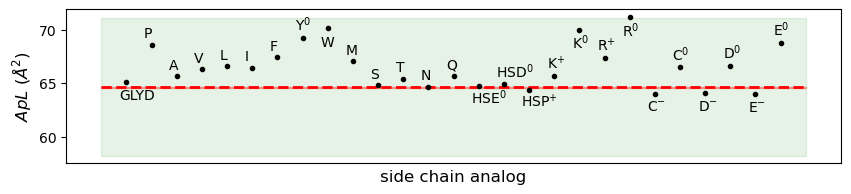

In [35]:
#ApL
#plot_all(ApL, skip, 'A_L', 'ApL ($\AA$$^{2}$)')

df=plot_all(True, ApL, skip, 'A_L', '$ApL$ ($\AA$$^{2}$)')
#display(df)

#plt.legend(fontsize=12)

apl=apl_POPC['k'][0]
apl_error=apl_POPC['e'][0]
plt.fill_between([-1, len(ll)], [apl-0.1*apl, apl-0.1*apl],[apl+0.1*apl, apl+0.1*apl], color='green', alpha=0.1)
plt.fill_between([-1, len(ll)], [apl-apl_error, apl-apl_error],[apl+apl_error, apl+apl_error], color='red', alpha=0.3)
plt.plot([-1, len(ll)], [apl, apl], color='r', linestyle='--', linewidth=2)

for l in range(len(ll)):
    if df['aa'][l] in ['GLYD']:
        plt.text(l-0.3, df['k'][l]-0.025*df['k'][l], ll[l])
    elif df['aa'][l] in ['SCHE', 'SCW', 'SCKN', 'SCRN', 'SCHP-N', 'SCE-N', 'SCCM-N', 'SCD-N']:
        plt.text(l-0.3, df['k'][l]-0.025*df['k'][l], ll[l])
    else:
        plt.text(l-0.3, df['k'][l]+0.01*df['k'][l], ll[l])


plt.savefig('plot_ApL_all_tiny_{}.png'.format(ext), bbox_inches='tight')
#plt.ylim([apl_POPC-15, apl_POPC+15])
plt.show()


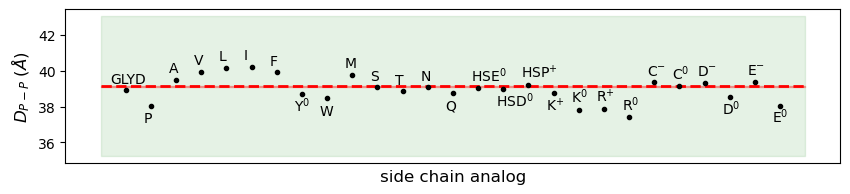

In [36]:
#Thickness
df=plot_all(True, thickness, skip, 'thickness', '$D_{P-P}$ ($\AA$)')
#display(df)
#ajouter l'acide aminé SCE-1 et SCD-1 et SCCM-1


#plt.legend(fontsize=12)

thk=thk_POPC['k'][0]
thk_error=thk_POPC['e'][0]
plt.fill_between([-1, len(ll)], [thk-0.1*thk, thk-0.1*thk],[thk+0.1*thk, thk+0.1*thk], color='green', alpha=0.1)
plt.fill_between([-1, len(ll)], [thk-thk_error, thk-thk_error],[thk+thk_error, thk+thk_error], color='red', alpha=0.3)

plt.plot([-1, len(ll)], [thk, thk], color='r', linestyle='--', linewidth=2)

for l in range(len(ll)):
    if df['aa'][l] in ['GLYD']:
        plt.text(l-0.6, df['k'][l]+0.01*df['k'][l], ll[l])
    elif df['aa'][l] in ['SCHD', 'SCY', 'SCP', 'SCK-N', 'SCQ', 'SCDN', 'SCEN', 'SCW']:
        plt.text(l-0.3, df['k'][l]-0.025*df['k'][l], ll[l])
    elif df['aa'][l] in ['']:
        plt.text(l-0.3, df['k'][l]+0.01*df['k'][l], ll[l])
    else:
        plt.text(l-0.3, df['k'][l]+0.01*df['k'][l], ll[l])

plt.savefig('plot_thk_all_tiny_{}.png'.format(ext), bbox_inches='tight', transparent=True)
plt.show()

In [ ]:
profiles = ["total", "water", "popc", "choline", "phosphate", "carbonyl", "chains"]
profile = ["total", "water", "phosphate", "chains"]
name = ['Total', 'Water', 'PO$_4$', 'Choline', '' 'Chains']


traj=[1, 2, 3]
d=make_ab2c_dens(aa)
#display(d[0])
plt.figure(figsize=(10,2))
#plt.scatter(aa, d[0], marker='+', color='k', linewidth=5, label=profiles[0])
for i in range(1,len(profile)):
    plt.plot(aa, d[i], linewidth=1, linestyle='-', label=name[i])
#plt.scatter(aa, areas_p[6], marker='.', linewidth=1, linestyle='-', label=profiles[6])
#ajouter l'acide aminé SCE-1 et SCD-1 et SCCM-1
"""
traj=[1]
x=['SCE-1', 'SCD-1', 'SCCM-1', 'SCE-05', 'SCD-05', 'SCCM-05']
y=[]
d=make_ab2c_dens(x)
x=['SCE', 'SCD', 'SCCM', 'SCE', 'SCD', 'SCCM']

print(dfy, dfy[0])
plt.scatter(x, d[0], marker='+', color='g', linewidth=1, label='total (0.10M)')
#plt.text(x, y-2, ' 0.10M', color='g')
"""

#plt.plot([-1, len(ll)], [0,0], color='red', linestyle='--', linewidth=2, alpha=0.5)
plt.legend(loc=[1.05, 0.45], fontsize=12)
#plt.xlabel("Analogue d'acide aminé")
#plt.ylabel('Aire entre les MDP', fontsize=12)
#plt.savefig('dens_tiny.png', bbox_inches='tight', transparent=True)

#plt.show()
#print(df_moy, df)

#plt.figure(figsize=(8,2))
plt.scatter(aa, d[0], marker='+', color='k', linewidth=5, label=name[0])
#plt.plot([-1, len(ll)], [0,0], color='red', linestyle='--', linewidth=2, alpha=0.5)
for l in range(len(ll)):
    if aa[l] in ['SCHE', 'SCHP-N']:
        plt.text(aa[l], d[0][l]-0.9*d[0][l], ll[l])
    else:
        plt.text(aa[l], d[0][l]+0.15*d[0][l], ll[l])


plt.legend(loc='upper right', ncols=2, fontsize=10)
plt.xlabel("side chain analog", fontsize=12)
plt.ylabel('MDP deviation', fontsize=12)
plt.ylim([0, 2])
plt.xticks([])
plt.savefig('dens_tot_tiny_{}.png'.format(ext), bbox_inches='tight', transparent=True)
plt.show()

#remettre le bon nombre de trajectoires
traj=[1, 2, 3]


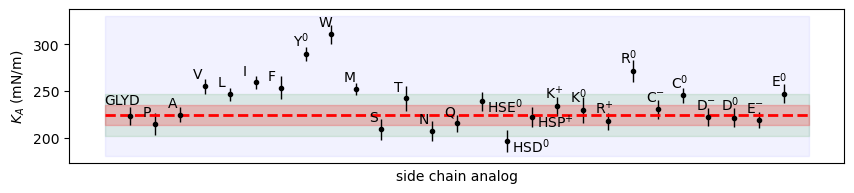

In [38]:
#Area Compressibility Modulus
if cell_launch==0:
    df=area_compressibility_modulus(aa, True, skip)


plt.figure(figsize=(10,2))

plt.errorbar(df['aa'], df['k'], df['e'], color='k', linewidth=1, fmt='.')
#plt.scatter(k['aa'], k['k'], marker='+', color='k', linewidth=5)
"""
#ajouter l'acide aminé SCE-1 et SCD-1 et SCCM-1
traj=[1]

x=['SCE-05-N', 'SCD-05-N', 'SCCM-05-N']
y=[]
y=area_compressibility_modulus(x, True, skip)
#print(y)
x=['SCE-N', 'SCD-N', 'SCCM-N']
plt.scatter(x, y['k'], marker='x', color='b', linewidth=1, label='0.05M')
#plt.text(x, y-2, ' 0.10M', color='g')

x=['SCE-1-N', 'SCD-1-N', 'SCCM-1-N']
y=[]
y=area_compressibility_modulus(x, True, skip)
#print(y)
x=['SCE-N', 'SCD-N', 'SCCM-N']
plt.scatter(x, y['k'], marker='x', color='g', linewidth=1, label='0.10M')
#plt.text(x, y-2, ' 0.10M', color='g')
"""

#plt.legend()

for l in range(len(ll)):
    if aa[l] in ['SCHE', 'SCHP-N', 'SCHD']:
        plt.text(l+0.2, df['k'][l]-12, ll[l])
    elif aa[l] in ['GLYD']:
        plt.text(l-1, df['k'][l]+12, ll[l])
    else:
        plt.text(l-0.5, df['k'][l]+8, ll[l])

acm=acm_POPC['k'][0]
error_acm=acm_POPC['e'][0]
plt.fill_between([-1, len(ll)], [180, 180],[330, 330], color='blue', alpha=0.05)
plt.fill_between([-1, len(ll)], [acm-0.1*acm, acm-0.1*acm],[acm+0.1*acm, acm+0.1*acm], color='green', alpha=0.1)
plt.fill_between([-1, len(ll)], [acm-error_acm, acm-error_acm],[acm+error_acm, acm+error_acm], color='red', alpha=0.2)
plt.plot([-1, len(ll)], [acm, acm], color='r', linestyle='--', linewidth=2)
plt.xticks([])

plt.xlabel('side chain analog')
plt.ylabel('$K_A$ (mN/m)')
plt.savefig('plot_acm_tiny.png', bbox_inches='tight')

plt.show()
cell_launch=1

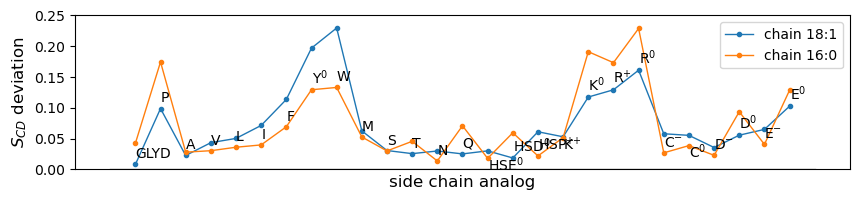

In [42]:
chain=["chain2", "chain3"]

area2=[]
area3=[]

#df for popc only
#create a df for each traj
df_21, df_31 = df_scd('1', '')
df_22, df_32 = df_scd('2', '')
df_23, df_33 = df_scd('3', '')

#merge the df
df0_chain2=merge_carbon(df_21, df_22, df_23, range(2, 19))
df0_chain3=merge_carbon(df_31, df_32, df_33, range(2, 17))


for acid in aa:
    #create a df for each traj
    if acid in ['GLYD', 'SCA', 'SCV', 'SCP', 'SCW']:
        traj_num=['4','2','3']
    else:
        traj_num=['1','2','3']
    df_21, df_31 = df_scd(traj_num[0], '-'+acid)
    df_22, df_32 = df_scd(traj_num[1], '-'+acid)
    df_23, df_33 = df_scd(traj_num[2], '-'+acid)

    #merge the df
    df_chain2=merge_carbon(df_21, df_22, df_23, range(2, 19))
    df_chain3=merge_carbon(df_31, df_32, df_33, range(2, 17))
    #print(df_chain2)
    
    area2.append(make_ab2c_dop(df0_chain2, df_chain2))
    area3.append(make_ab2c_dop(df0_chain3, df_chain3))

plt.figure(figsize=(10,2))

plt.plot(ll, area2, label='chain 18:1', marker='.', linewidth=1)
plt.plot(ll, area3, label='chain 16:0', marker='.', linewidth=1)
"""
area2=[]
area3=[]
x=['SCE', 'SCD', 'SCCM']
for acid in x:
    #create a df for each traj
    df_chain2, df_chain3 = df_scd('1', '-'+acid+'-1-N')
    
    area2.append(make_ab2c_dop(df0_chain2, df_chain2))
    area3.append(make_ab2c_dop(df0_chain3, df_chain3))

#print(area2)
x2=['SCE-N', 'SCD-N', 'SCCM-N']
plt.scatter(x2, area2, label='chain 18:1 (0.10M)', marker='+', color='olivedrab', linewidth=1)
plt.scatter(x2, area3, label='chain 16:0 (0.10M)', marker='+', color='darkgreen', linewidth=1)

area2=[]
area3=[]
for acid in x:
    #create a df for each traj
    df_chain2, df_chain3 = df_scd('1', '-'+acid+'-05-N')
    
    area2.append(make_ab2c_dop(df0_chain2, df_chain2))
    area3.append(make_ab2c_dop(df0_chain3, df_chain3))

#print(area2)
plt.scatter(x2, area2, label='chain 18:1 (0.05M)', marker='+', color='deepskyblue', linewidth=1)
plt.scatter(x2, area3, label='chain 16:0 (0.05M)', marker='+', color='darkblue', linewidth=1)
"""
plt.plot([-1, len(ll)], [0,0], color='k', linestyle='-', linewidth=1, alpha=0.5)
for l in range(len(ll)):
    if aa[l] in ['SCHE','SCK-N', 'SCC']:
        plt.text(ll[l], min([area2[l], area3[l]])-0.02, ll[l])
    else:
        plt.text(ll[l], min([area2[l], area3[l]])+0.01, ll[l])
plt.ylim([0, 0.25])
plt.legend(loc='upper right', fontsize=10)
plt.xlabel("side chain analog", fontsize=12)
plt.ylabel('$S_{CD}$ deviation', fontsize=12)
plt.xticks([])
plt.savefig('dop_tiny_{}.png'.format(ext), bbox_inches='tight', transparent=True)
plt.show()

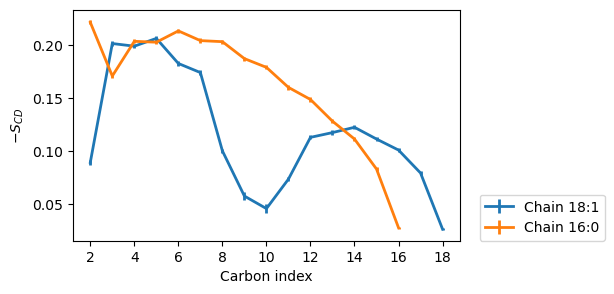

In [217]:
# montrer Scd de membrane seule
prop_cycle = plt.rcParams['axes.prop_cycle']
color=prop_cycle.by_key()['color']
plt.figure(figsize=(5,3))
#POPC Scd
chain=["chain2", "chain3"]

area2=[]
area3=[]
#create a df for each traj
df_21, df_31 = df_scd('1', '')
df_22, df_32 = df_scd('2', '')
df_23, df_33 = df_scd('3', '')

#merge the df
df0_chain2=merge_carbon(df_21, df_22, df_23, range(2, 19))
df0_chain3=merge_carbon(df_31, df_32, df_33, range(2, 17))

#display(df0_chain2)
plt.errorbar(df0_chain2['Carbon'], df0_chain2['-SCD'], df0_chain2['STD_Error'], label='Chain 18:1', fmt='-', color=color[0], linewidth=2.0, alpha=1)
plt.errorbar(df0_chain3['Carbon'], df0_chain3['-SCD'], df0_chain3['STD_Error'], label='Chain 16:0', fmt='-', color=color[1], linewidth=2.0, alpha=1)

plt.legend(loc=[1.05, 0])
plt.xlabel('Carbon index')
plt.ylabel('$-S_{CD}$')
#plt.title('MDP of POPC ')
plt.savefig('plot_scd_popc.png', bbox_inches='tight', transparent=True)
plt.show()

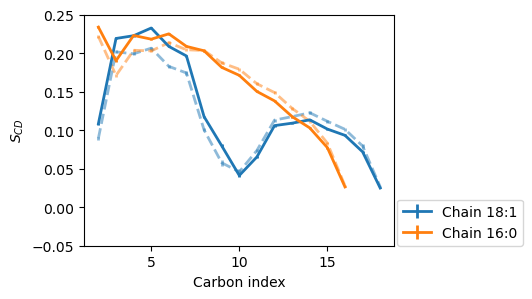

In [218]:
# montrer l'écart entre Scd de SCD et Scd de membrane seule
prop_cycle = plt.rcParams['axes.prop_cycle']
color=prop_cycle.by_key()['color']
plt.figure(figsize=(4,3))
#POPC Scd
chain=["chain2", "chain3"]

area2=[]
area3=[]
#create a df for each traj
df_21, df_31 = df_scd('1', '')
df_22, df_32 = df_scd('2', '')
df_23, df_33 = df_scd('3', '')

#merge the df
df0_chain2=merge_carbon(df_21, df_22, df_23, range(2, 19))
df0_chain3=merge_carbon(df_31, df_32, df_33, range(2, 17))

#display(df0_chain2)
plt.errorbar(df0_chain2['Carbon'], df0_chain2['-SCD'], df0_chain2['STD_Error'], fmt='--', color=color[0], linewidth=2.0, alpha=0.5)
plt.errorbar(df0_chain3['Carbon'], df0_chain3['-SCD'], df0_chain3['STD_Error'], fmt='--', color=color[1], linewidth=2.0, alpha=0.5)

#create a df for each traj
df_21, df_31 = df_scd('1', '-'+'SCW')
df_22, df_32 = df_scd('2', '-'+'SCW')
df_23, df_33 = df_scd('3', '-'+'SCW')

#merge the df
df_chain2=merge_carbon(df_21, df_22, df_23, range(2, 19))
df_chain3=merge_carbon(df_31, df_32, df_33, range(2, 17))
#print(df_chain2)

plt.errorbar(df_chain2['Carbon'], df_chain2['-SCD'], df_chain2['STD_Error'], label='Chain 18:1', color=color[0], linewidth=2.0)
plt.errorbar(df_chain3['Carbon'], df_chain3['-SCD'], df_chain3['STD_Error'], label='Chain 16:0', color=color[1], linewidth=2.0)

plt.legend(loc=[1.01, 0])
plt.ylim(-0.05, 0.25)
plt.xlabel('Carbon index')
plt.ylabel('$S_{CD}$')
#plt.title('MDP of POPC ')
plt.savefig('plot_scdvscw-tiny.png', bbox_inches='tight', transparent=True)
plt.show()

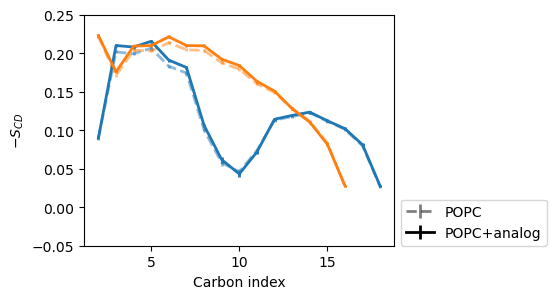

In [219]:
# montrer l'écart entre Scd de SCD-05 et Scd de membrane seule
prop_cycle = plt.rcParams['axes.prop_cycle']
color=prop_cycle.by_key()['color']
plt.figure(figsize=(4,3))
#POPC Scd
chain=["chain2", "chain3"]

area2=[]
area3=[]
#create a df for each traj
df_21, df_31 = df_scd('1', '')
df_22, df_32 = df_scd('2', '')
df_23, df_33 = df_scd('3', '')

#merge the df
df0_chain2=merge_carbon(df_21, df_22, df_23, range(2, 19))
df0_chain3=merge_carbon(df_31, df_32, df_33, range(2, 17))

#display(df0_chain2)
plt.errorbar([], [], [], label='POPC', fmt='--', color='k', linewidth=2.0, alpha=0.5)
plt.errorbar(df0_chain2['Carbon'], df0_chain2['-SCD'], df0_chain2['STD_Error'], fmt='--', color=color[0], linewidth=2.0, alpha=0.5)
plt.errorbar(df0_chain3['Carbon'], df0_chain3['-SCD'], df0_chain3['STD_Error'], fmt='--', color=color[1], linewidth=2.0, alpha=0.5)
#create a df for each traj
df_21, df_31 = df_scd('1', '-'+'SCD-N')
#print(df_chain2)

plt.errorbar([], [], [], label='POPC+analog', fmt='-', color='k', linewidth=2.0)
plt.errorbar(df_21['Carbon'], df_21['-SCD'], df_21['STD_Error'], color=color[0], linewidth=2.0)
plt.errorbar(df_31['Carbon'], df_31['-SCD'], df_31['STD_Error'], color=color[1], linewidth=2.0)

plt.legend(loc=[1.02, 0])
plt.ylim(-0.05, 0.25)
plt.xlabel('Carbon index')
plt.ylabel('$-S_{CD}$')
#plt.title('MDP of POPC ')
plt.savefig('plot_scdvscd-05.png', bbox_inches='tight', transparent=True)
plt.show()